# # EE4375-2022: Sixth Lab Session: Galerkin Finite Element Method for the Poisson Equation on the Unit Square 

Solves the Poisson equation $- \bigtriangleup u = f$ on the unit square domain $\Omega=(-0.5,0.5)^2$ supplied with the homogeneous Dirichlet boundary condition $u = 0$ on $\Gamma$. The computational domain is kept simple on purpose for illustration purposes. The source function $f$ is defined as the sourcefct in what follows. Linear finite elements on triangular elements are used. The mesh is generated using the mesh generation software called gmsh (see [Gmsh](https://gmsh.info)). 

## Import Packages

In [1]:
import Gmsh: gmsh 
using GR 
using LinearAlgebra
using Plots
using LaTeXStrings

## Unit Square Example

Exercises: 
1. study the assembly of the vector;
2. study the assembly of the matrix; 

The mesh density is controlled by the parameter lc. This parameter works relative to the dimensions of the geometry. 

In [2]:
gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 1)
gmsh.model.add("t1")
lc = 5e-1
gmsh.model.geo.addPoint(0, 0, 0, lc, 1)
gmsh.model.geo.addPoint(1., 0,  0, lc, 2)
gmsh.model.geo.addPoint(1., 1., 0, lc, 3)
gmsh.model.geo.addPoint(0, 1., 0, lc, 4)
gmsh.model.geo.addLine(1, 2, 5)
gmsh.model.geo.addLine(2, 3, 6)
gmsh.model.geo.addLine(3, 4, 7)
gmsh.model.geo.addLine(4, 1, 8)
gmsh.model.geo.addCurveLoop([5, 6, 7, 8], 9)
gmsh.model.geo.addPlaneSurface([9], 10)
gmsh.model.addPhysicalGroup(0, [1, 2], 1)
gmsh.model.addPhysicalGroup(1, [1, 2], 2)
gmsh.model.addPhysicalGroup(2, [10], 11)
gmsh.model.setPhysicalName(2, 11, "My surface")
gmsh.model.geo.synchronize()
gmsh.model.mesh.generate(2)
#gmsh.write("t1.msh")
#gmsh.finalize()

Info    : Meshing 1D...
Info    : Meshing curve 5 (Line)
Info    : Meshing curve 6 (Line)
Info    : Meshing curve 7 (Line)
Info    : Meshing curve 8 (Line)
Info    : Done meshing 1D (0.000537 s)
Info    : Meshing 2D...
Info    : Meshing surface 10 (Plane, Delaunay)
Info    : Done meshing 2D (0.000426 s)
Info    : 13 vertices 28 elements


In [1]:
?sortslices

search: sortslices



```
sortslices(A; dims, alg::Algorithm=DEFAULT_UNSTABLE, lt=isless, by=identity, rev::Bool=false, order::Ordering=Forward)
```

Sort slices of an array `A`. The required keyword argument `dims` must be either an integer or a tuple of integers. It specifies the dimension(s) over which the slices are sorted.

E.g., if `A` is a matrix, `dims=1` will sort rows, `dims=2` will sort columns. Note that the default comparison function on one dimensional slices sorts lexicographically.

For the remaining keyword arguments, see the documentation of [`sort!`](@ref).

# Examples

```jldoctest
julia> sortslices([7 3 5; -1 6 4; 9 -2 8], dims=1) # Sort rows
3×3 Matrix{Int64}:
 -1   6  4
  7   3  5
  9  -2  8

julia> sortslices([7 3 5; -1 6 4; 9 -2 8], dims=1, lt=(x,y)->isless(x[2],y[2]))
3×3 Matrix{Int64}:
  9  -2  8
  7   3  5
 -1   6  4

julia> sortslices([7 3 5; -1 6 4; 9 -2 8], dims=1, rev=true)
3×3 Matrix{Int64}:
  9  -2  8
  7   3  5
 -1   6  4

julia> sortslices([7 3 5; 6 -1 -4; 9 -2 8], dims=2) # Sort columns
3×3 Matrix{Int64}:
  3   5  7
 -1  -4  6
 -2   8  9

julia> sortslices([7 3 5; 6 -1 -4; 9 -2 8], dims=2, alg=InsertionSort, lt=(x,y)->isless(x[2],y[2]))
3×3 Matrix{Int64}:
  5   3  7
 -4  -1  6
  8  -2  9

julia> sortslices([7 3 5; 6 -1 -4; 9 -2 8], dims=2, rev=true)
3×3 Matrix{Int64}:
 7   5   3
 6  -4  -1
 9   8  -2
```

# Higher dimensions

`sortslices` extends naturally to higher dimensions. E.g., if `A` is a a 2x2x2 array, `sortslices(A, dims=3)` will sort slices within the 3rd dimension, passing the 2x2 slices `A[:, :, 1]` and `A[:, :, 2]` to the comparison function. Note that while there is no default order on higher-dimensional slices, you may use the `by` or `lt` keyword argument to specify such an order.

If `dims` is a tuple, the order of the dimensions in `dims` is relevant and specifies the linear order of the slices. E.g., if `A` is three dimensional and `dims` is `(1, 2)`, the orderings of the first two dimensions are re-arranged such that the slices (of the remaining third dimension) are sorted. If `dims` is `(2, 1)` instead, the same slices will be taken, but the result order will be row-major instead.

# Higher dimensional examples

```
julia> A = permutedims(reshape([4 3; 2 1; 'A' 'B'; 'C' 'D'], (2, 2, 2)), (1, 3, 2))
2×2×2 Array{Any, 3}:
[:, :, 1] =
 4  3
 2  1

[:, :, 2] =
 'A'  'B'
 'C'  'D'

julia> sortslices(A, dims=(1,2))
2×2×2 Array{Any, 3}:
[:, :, 1] =
 1  3
 2  4

[:, :, 2] =
 'D'  'B'
 'C'  'A'

julia> sortslices(A, dims=(2,1))
2×2×2 Array{Any, 3}:
[:, :, 1] =
 1  2
 3  4

[:, :, 2] =
 'D'  'C'
 'B'  'A'

julia> sortslices(reshape([5; 4; 3; 2; 1], (1,1,5)), dims=3, by=x->x[1,1])
1×1×5 Array{Int64, 3}:
[:, :, 1] =
 1

[:, :, 2] =
 2

[:, :, 3] =
 3

[:, :, 4] =
 4

[:, :, 5] =
 5
```


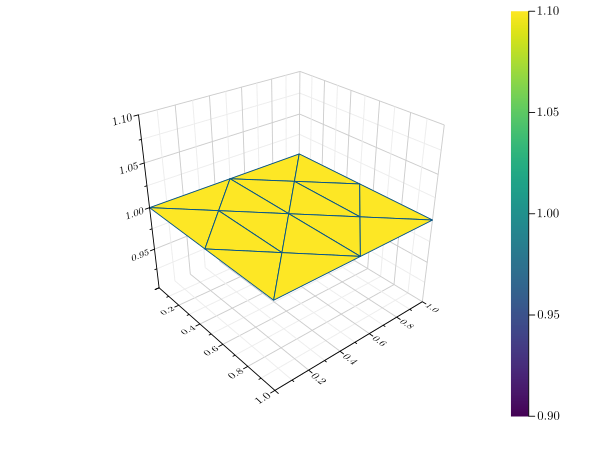

In [3]:
#..2/11 Get and sort the mesh nodes
#..Observe that although the mesh is two-dimensional,
#..the z-coordinate that is equal to zero is stored as well.
#..Observe that the coordinates are stored contiguously for computational
#..efficiency
node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
nnodes = length(node_ids)
#..sort the node coordinates by ID, such that Node one sits at row 1
tosort = [node_ids node_coord[1:3:end] node_coord[2:3:end]];
sorted = sortslices(tosort , dims = 1);
node_ids = sorted[:,1]
xnode = sorted[:,2]
ynode = sorted[:,3]

#..3/11 Plotting the mesh
z = ones(length(xnode))
trisurf(xnode,ynode,z)

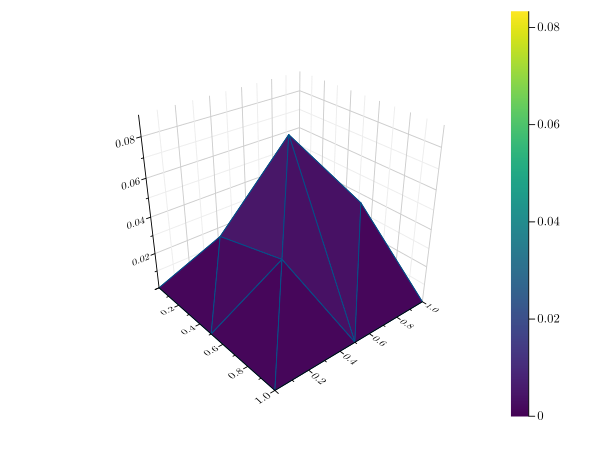

In [4]:
#..4/11 Get the mesh elements
#..observe that we get all the two-dimensional triangular elements from the mesh
element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(2)
nelements = length(element_ids[1])

#..5/11 Define the source function and apply the source function to the local coordinates
sourcefunction(x,y) = x+y
fvalues = map(sourcefunction, xnode, ynode)

#..6/11 initialize global matrix A and global vector f
#..observe that for simplicity we use dense matrix here
A = zeros(nnodes,nnodes)
f = zeros(nnodes,1)

#..7/11 Perform a loop over the elements
for element_id in 1:nelements

  #....retrieve global numbering of the local nodes of the current element
  node1_id = element_connectivity[1][3*(element_id-1)+1]
  node2_id = element_connectivity[1][3*(element_id-1)+2]
  node3_id = element_connectivity[1][3*(element_id-1)+3]

  #....retrieve the x and y coordinates of the local nodes of the current element
  xnode1 = xnode[node1_id]; xnode2 = xnode[node2_id]; xnode3 = xnode[node3_id];
  ynode1 = ynode[node1_id]; ynode2 = ynode[node2_id]; ynode3 = ynode[node3_id];

  #....compute surface area of the current element
  x12 = xnode2 - xnode1; x13 = xnode3-xnode1;
  y12 = ynode2 - ynode1; y13 = ynode3-ynode1;
  area_id = x12*y13 - x13*y12; area_id = abs(area_id)/2

  #....if desired, print global number numbers and element area to screen
  if (false)
    println("on element ", element_id, " node-1 has global number ", node1_id)
    println("on element ", element_id, " node-2 has global number ", node2_id)
    println("on element ", element_id, " node-3 has global number ", node3_id)
    println("on element ", element_id, " area = ", area_id)
    println(" ")
  end

  #....compute local vector contribution floc of the current element
  floc = area_id/3*[fvalues[node1_id]; fvalues[node2_id]; fvalues[node3_id]]

  #....compute local matrix contribution Aloc of the current element
  Emat = [[xnode1;xnode2;xnode3] [ynode1;ynode2;ynode3] [1;1;1]]\UniformScaling(1.);
  Emat[3,:] .= 0;
  Aloc = area_id*(transpose(Emat)*Emat);

  #....perform loop over nodes of the current element
  #....and add local contribution Aloc to global matrix entity A
  for i = 1:3
  I = element_connectivity[1][3*(element_id-1)+i]
    f[I] += floc[i]
    for j = 1:3
      J = element_connectivity[1][3*(element_id-1)+j]
      A[I,J] += Aloc[i,j]
    end
  end

end

#..8/11 Handle the boundary conditions
#..retrieve boundary nodes by loop over corner point and boundary edges
node_ids1, node_coord, _ = gmsh.model.mesh.getNodes(0,1)
node_ids2, node_coord, _ = gmsh.model.mesh.getNodes(0,2)
node_ids3, node_coord, _ = gmsh.model.mesh.getNodes(0,3)
node_ids4, node_coord, _ = gmsh.model.mesh.getNodes(0,4)
node_ids5, node_coord, _ = gmsh.model.mesh.getNodes(1,5)
node_ids6, node_coord, _ = gmsh.model.mesh.getNodes(1,6)
node_ids7, node_coord, _ = gmsh.model.mesh.getNodes(1,7)
node_ids8, node_coord, _ = gmsh.model.mesh.getNodes(1,8)
bnd_node_ids = union(node_ids1,node_ids2,node_ids3,node_ids4,node_ids5,node_ids6,node_ids7,node_ids8)
A[bnd_node_ids,:] .= 0;
A[bnd_node_ids,bnd_node_ids] = Diagonal(ones(size(bnd_node_ids)))
f[bnd_node_ids] .= 0;

#..9/11 Compute the numerical solution
u = A\f

#..10/11 Plot the numerical solution
# tricont(xnode,ynode,u)
trisurf(xnode,ynode,u)